In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import scipy

import seaborn as sns
import bokeh.plotting

sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5)

I wanted to just get started with a simple Data Science project, so I found this interesting time-series/categorical dataset from the UCI Machine Learning Repository.

It is "experimental data used for binary classification (room occupancy) from Temperature,Humidity,Light and CO2. Ground-truth occupancy was obtained from time stamped pictures that were taken every minute."

Let's load the data and get started.
Data source: http://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

In [2]:
full_DatFrame = pd.read_csv('../dat/datatraining.txt')
full_DatFrame[:5]

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


We can plot the time-series data of the occupancy.  
Then we can count the number of transitions (i.e. 1 to 0 or 0 to 1) where 1 is occupied and 0 is unoccupied.

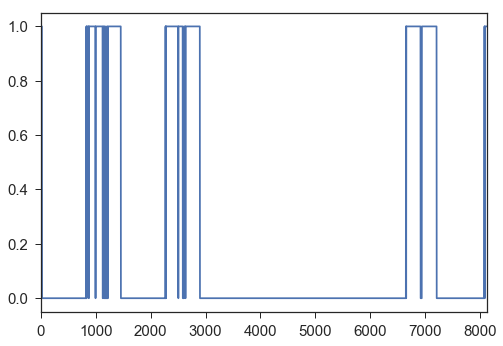

In [3]:
full_DatFrame['Occupancy'].plot()
plt.show()

In [4]:
occup_trj = np.array(full_DatFrame['Occupancy'])
num_trans = (occup_trj[:-1] - occup_trj[1:] != 0).sum()
print("Number of transitions = ", num_trans)

Number of transitions =  40


Interesting.  The office room has two states: occupied (1) or unoccupied (0), and we can see 40 transitions between these two states.  

Given my background in chemical physics, this reminds me of a two state Markov model.

In [5]:
from IPython.display import Image

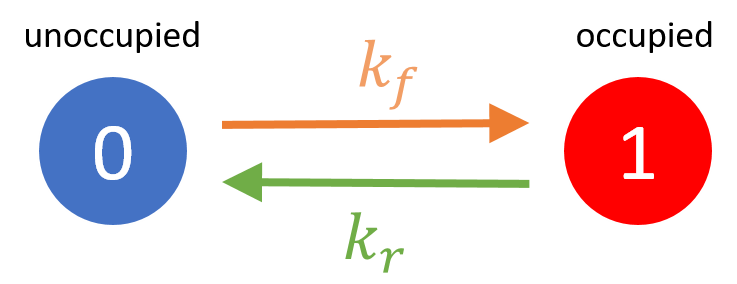

In [6]:
Image("../images/2state_markov.png", width=400)

The above diagram of the two state Markov process where both foward and reverse transitions are possible.
k_f and k_r represent the transition rates

* It should be noted that that bringing up Markov processes at this point is a bit premature.  Markov processes have no history depenendence.  In other words the transition probabilities only depend on the current state.  But I do think this is an intuitive way to begin thinking about the problem.

If we are to use a model like this, we should check to see if the unoccupied and occupied states are distinctly different.
In other words, are the distribution of other attributes (e.g. temperature, humidity, etc) distinctly different?

Let's startby plotting some scatter plots of each state.

But before we do that we should see if we can reduce the number of attributes we are dealing with.
We currently have 5 (not counting occupancy), so there are 10 possible pairs of attributes we can plot at a time.
Let's see if any of them are highly correlated with each other.

* We can probably expect to see that "humidity" and "humidity ratio" are redundant attributes

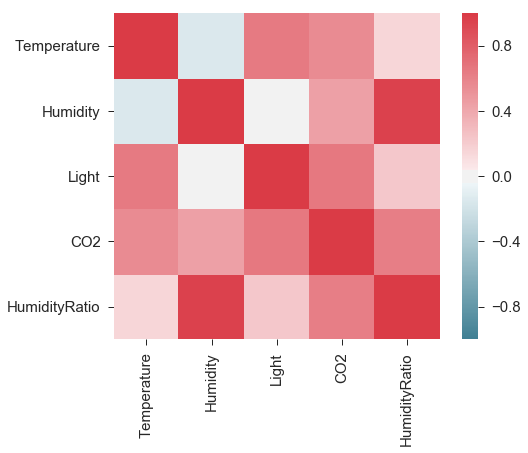

In [7]:
df = full_DatFrame.drop(['Occupancy','date'], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [8]:
df_0 = full_DatFrame[full_DatFrame['Occupancy'] == 0].drop(['date'], axis=1)
df_0[:5]

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
17,23.000,27.20,0.0,681.5,0.004728,0
18,22.945,27.29,0.0,685.0,0.004728,0
19,22.945,27.39,0.0,685.0,0.004745,0
20,22.890,27.39,0.0,689.0,0.004730,0
21,22.890,27.39,0.0,689.5,0.004730,0


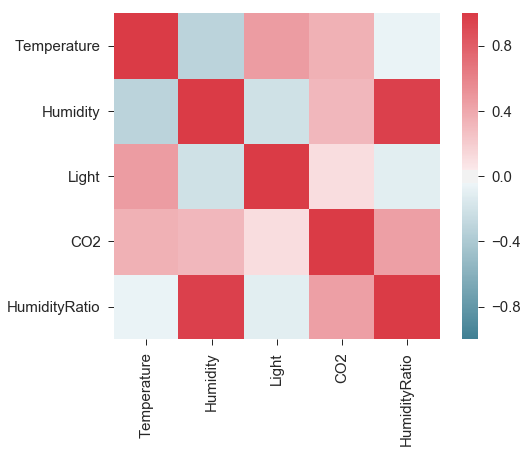

In [9]:
df_0 = df_0.drop(['Occupancy'], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
corr = df_0.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [10]:
df_1 = full_DatFrame[full_DatFrame['Occupancy'] == 1].drop(['date'], axis=1)
df_1[:5]

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,23.18,27.2720,426.0,721.25,0.004793,1
2,23.15,27.2675,429.5,714.00,0.004783,1
3,23.15,27.2450,426.0,713.50,0.004779,1
4,23.15,27.2000,426.0,708.25,0.004772,1
5,23.10,27.2000,426.0,704.50,0.004757,1


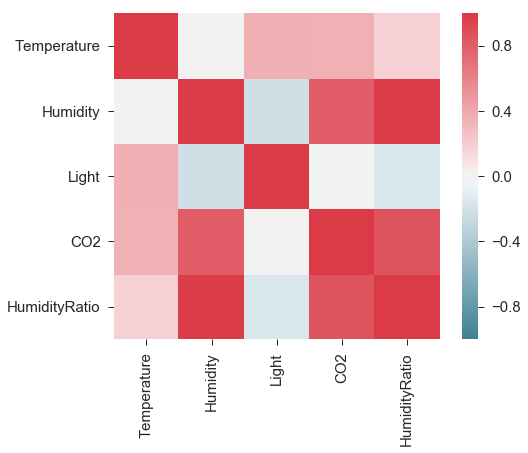

In [11]:
df_1 = df_1.drop(['Occupancy'], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
corr = df_1.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

As expected, "humidity" and "humidity ratio" are VERY correlated.
"CO2" seems pretty correlated to "humidity" and "humidity ratio" as well, but not nearly as strong.

Removing "humidity ratio" from consideration, let's see if we can distinguish occupied an unoccupied states with one or two attributes.

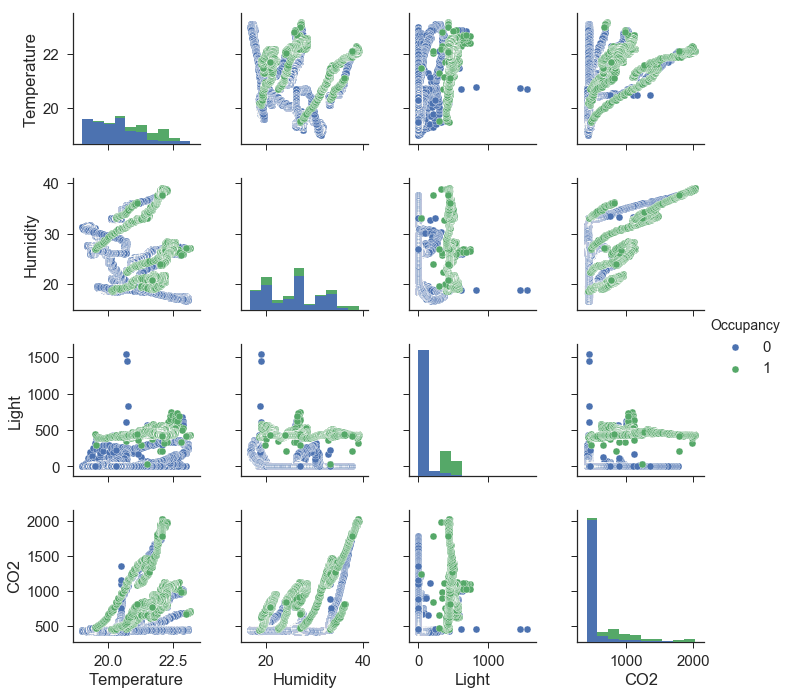

In [12]:
sns.pairplot(full_DatFrame, vars=['Temperature', 'Humidity', 'Light', 'CO2'], hue="Occupancy")
plt.show()

That isn't as pretty as I was hoping.  Haha.

The best single variable that se